### Connect to Drive

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

In [5]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [6]:
!pip install keras-tuner -q
import tensorflow as tf
import keras_tuner
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [7]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [8]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

numbers = [186,
           532,
           515,
           511,
           531,
           222,
           537,
           508,
]

#class_weights = {}
#class_mean = sum(numbers) / len(numbers)
#for i, n in enumerate(numbers):
#    class_weights[i] = (1 / n) * class_mean

#print(class_weights)

In [10]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_train_data_gen = ImageDataGenerator(rotation_range=20, 
                                        fill_mode='reflect',
                                        #height_shift_range=20,
                                        #width_shift_range=10,
                                        brightness_range=[0.7,1.2],
                                        zoom_range=0.3,
                                        vertical_flip=True,
                                        horizontal_flip=True,
                                        validation_split=0.2
                                       )

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

no_aug_data_gen = ImageDataGenerator(validation_split=0.2)

train_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="training",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=True,
                                                seed=seed)

valid_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="validation",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=False,
                                                seed=seed)

Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [24]:
from sklearn.metrics import classification_report

def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    while batch_index <= validation_dataset.batch_index:
        data = validation_dataset.next()

        for i in range(len(data[0])):
            data_list.append(data[0][i])
            label_list.append(data[1][i])

        batch_index = batch_index + 1

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

### Models metadata

In [12]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [13]:
def load_all_models(model_names):
    all_models = []
    for model_name in model_names:
        filename = os.path.join('../input/ann-newft/', model_name)
        model = tfk.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

In [14]:
model_names = ['EfficientNet/EfficientNet', 'ResNet/ResNet', 'Xception/Xception']
models = load_all_models(model_names)

2022-11-21 21:20:58.512538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:20:58.670740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:20:58.671645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:20:58.673695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

loaded: ../input/ann-newft/EfficientNet/EfficientNet
loaded: ../input/ann-newft/ResNet/ResNet
loaded: ../input/ann-newft/Xception/Xception


In [15]:
for model in models:
    evaluate_classes_performance(model, valid_gen)

2022-11-21 21:22:11.143184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-21 21:22:16.598246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


              precision    recall  f1-score   support

           0       0.61      0.46      0.52        37
           1       0.92      0.92      0.92       106
           2       0.87      0.94      0.91       103
           3       0.85      0.83      0.84       102
           4       0.87      0.88      0.87       106
           5       0.90      0.86      0.88        44
           6       0.93      0.99      0.96       107
           7       0.82      0.80      0.81       101

    accuracy                           0.87       706
   macro avg       0.85      0.84      0.84       706
weighted avg       0.87      0.87      0.87       706

              precision    recall  f1-score   support

           0       0.42      0.35      0.38        37
           1       0.88      0.86      0.87       106
           2       0.80      0.86      0.83       103
           3       0.86      0.85      0.86       102
           4       0.86      0.84      0.85       106
           5       0.87 

In [16]:
for i, model in enumerate(models):
    models[i]._name = f"model_{i}"
    for layer in model.layers:
        layer.trainable = False

In [17]:
ensemble_outputs = [model.output for model in models]
input_layer = tfk.Input(shape=input_shape)
ensemble_outputs = [model(input_layer) for model in models]
merge = tfkl.concatenate(ensemble_outputs)
merge = tfkl.Dense(
    10, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(merge)
output = tfkl.Dense(
    8, 
    activation='softmax', 
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(merge)
ens_model = tf.keras.models.Model(inputs=input_layer, outputs=output)
ens_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tfk.losses.CategoricalCrossentropy(), 
    metrics=["accuracy"]
)

In [18]:
ens_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_0 (Functional)            (None, 8)            64821151    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8)            24157192    input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 8)            21453872    input_1[0][0]                    
______________________________________________________________________________________________

In [19]:
history = ens_model.fit(
    train_gen,
    epochs=epochs, 
    validation_data=valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
).history

Epoch 1/200
355/355 [==============================] - 64s 113ms/step - loss: 1.4580 - accuracy: 0.5949 - val_loss: 0.9807 - val_accuracy: 0.8626
Epoch 2/200
355/355 [==============================] - 31s 88ms/step - loss: 0.4233 - accuracy: 0.9503 - val_loss: 0.5116 - val_accuracy: 0.8839
Epoch 3/200
355/355 [==============================] - 31s 89ms/step - loss: 0.1265 - accuracy: 0.9933 - val_loss: 0.4351 - val_accuracy: 0.8895
Epoch 4/200
355/355 [==============================] - 32s 90ms/step - loss: 0.0510 - accuracy: 0.9972 - val_loss: 0.4378 - val_accuracy: 0.8938
Epoch 5/200
355/355 [==============================] - 32s 89ms/step - loss: 0.0308 - accuracy: 0.9958 - val_loss: 0.4479 - val_accuracy: 0.8924
Epoch 6/200
355/355 [==============================] - 32s 89ms/step - loss: 0.0220 - accuracy: 0.9958 - val_loss: 0.4632 - val_accuracy: 0.8938
Epoch 7/200
355/355 [==============================] - 32s 89ms/step - loss: 0.0152 - accuracy: 0.9975 - val_loss: 0.4828 - val_a

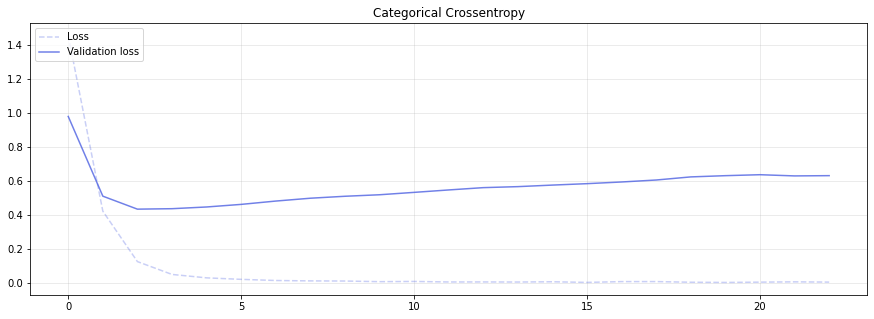

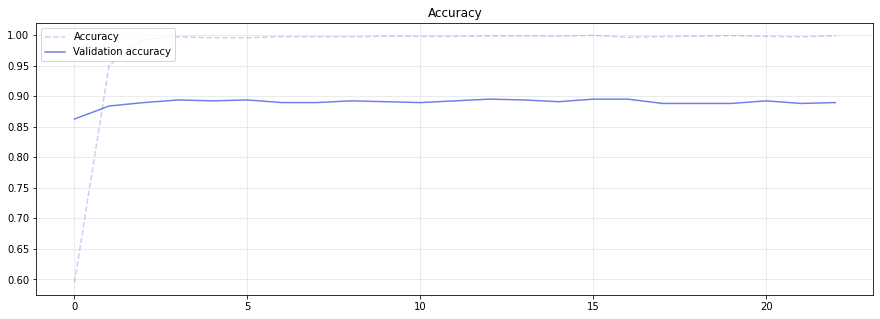

In [20]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
import shutil
ens_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

2022-11-21 21:36:47.683157: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/kaggle/working/ANN_Homework1_Model.zip'

In [25]:
evaluate_classes_performance(ens_model, valid_gen)

              precision    recall  f1-score   support

           0       0.61      0.51      0.56        37
           1       0.93      0.95      0.94       106
           2       0.86      0.96      0.91       103
           3       0.93      0.87      0.90       102
           4       0.90      0.90      0.90       106
           5       0.97      0.89      0.93        44
           6       0.97      0.99      0.98       107
           7       0.84      0.83      0.84       101

    accuracy                           0.90       706
   macro avg       0.88      0.86      0.87       706
weighted avg       0.89      0.90      0.89       706

